# Homework Starter — Stage 10b: Time Series & Classification
Fill in the TODOs. Use your own dataset or adapt the synthetic generator below.

In [1]:
# Imports
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, TimeSeriesSplit
np.random.seed(7); sns.set(); plt.rcParams['figure.figsize']=(9,4)

## Option A: Use Your Own Data (Recommended)
Load your data here (ensure a DateTime index for time series).

In [4]:
import pandas as pd
import numpy as np

csv_path = "/Users/wenshan/Downloads/ncr_ride_bookings.csv"
df = pd.read_csv(csv_path)

df['ts'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df = df.sort_values('ts').set_index('ts')

df['bk_status'] = df['Booking Status'].str.replace('"', '', regex=False)
df['is_completed'] = (df['bk_status'] == 'Completed').astype(int)

daily = df['is_completed'].resample('D').sum().to_frame('count')

daily['ret'] = daily['count'].pct_change()

display(daily.head(10))
print("Date range:", daily.index.min(), "→", daily.index.max(), "| days:", len(daily))


,count,ret
ts,,
2024-01-01,251,NaN
2024-01-02,240,-0.043825
2024-01-03,245,0.020833
2024-01-04,254,0.036735
2024-01-05,257,0.011811
2024-01-06,234,-0.089494
2024-01-07,271,0.158120
2024-01-08,250,-0.077491
2024-01-09,257,0.028000


Date range: 2024-01-01 00:00:00 → 2024-12-30 00:00:00 | days: 365


## Option B: Synthetic Generator (Use if you don't have data ready)

In [ ]:
# Synthetic series with regimes & jumps
n=500
dates=pd.bdate_range('2021-01-01', periods=n)
mu = np.where(np.arange(n)<n//2, 0.0003, -0.0001)
sigma = np.where(np.arange(n)<n//2, 0.01, 0.015)
eps = np.random.normal(mu, sigma)
jumps = np.zeros(n); jump_days = np.random.choice(np.arange(20,n-20), size=5, replace=False)
jumps[jump_days] = np.random.normal(0,0.05,size=len(jump_days))
rets = eps + jumps
price = 100*np.exp(np.cumsum(rets))
df = pd.DataFrame({'price':price}, index=dates)
df['ret'] = df['price'].pct_change().fillna(0.0)
df['log_ret'] = np.log1p(df['ret'])
df.head()

## Feature Engineering

In [5]:
df = daily.copy()

df['lag_1']      = df['ret'].shift(1)
df['lag_7']      = df['ret'].shift(7)

df['roll_mean_7'] = df['ret'].rolling(7).mean().shift(1)
df['roll_std_7']  = df['ret'].rolling(7).std().shift(1)

df['momentum_7'] = (df['count'] - df['count'].shift(7)) / df['count'].shift(7)

df['zscore_7']   = (df['ret'] - df['roll_mean_7']) / df['roll_std_7']

df['y_next_ret'] = df['ret'].shift(-1)
df['y_up']       = (df['y_next_ret'] > 0).astype(int)

df_feat = df.dropna().copy()

print("Final feature table shape:", df_feat.shape)
display(df_feat.head())


Final feature table shape: (356, 10)


,count,ret,lag_1,lag_7,roll_mean_7,roll_std_7,momentum_7,zscore_7,y_next_ret,y_up
ts,,,,,,,,,,
2024-01-09,257,0.028000,-0.077491,-0.043825,0.002384,0.084478,0.070833,0.303224,0.046693,1
2024-01-10,269,0.046693,0.028000,0.020833,0.012645,0.082263,0.097959,0.413888,0.029740,1
2024-01-11,277,0.029740,0.046693,0.036735,0.016339,0.083267,0.090551,0.160938,-0.104693,0
2024-01-12,248,-0.104693,0.029740,0.011811,0.015340,0.083023,-0.035019,-1.445780,-0.024194,0
2024-01-13,242,-0.024194,-0.104693,-0.089494,-0.001304,0.094704,0.034188,-0.241698,0.078512,1


## Split

In [6]:
cut = int(len(df_feat) * 0.8)
train, test = df_feat.iloc[:cut], df_feat.iloc[cut:]

features = ['lag_1', 'lag_7', 'roll_mean_7', 'roll_std_7', 'momentum_7', 'zscore_7']

X_tr, X_te = train[features], test[features]
y_tr_reg, y_te_reg = train['y_next_ret'], test['y_next_ret']
y_tr_clf, y_te_clf = train['y_up'],       test['y_up']

print(X_tr.shape, X_te.shape)


(284, 6) (72, 6)


## Pipeline + Model (Choose one track below)

RMSE = 0.068910 | MAE = 0.055456


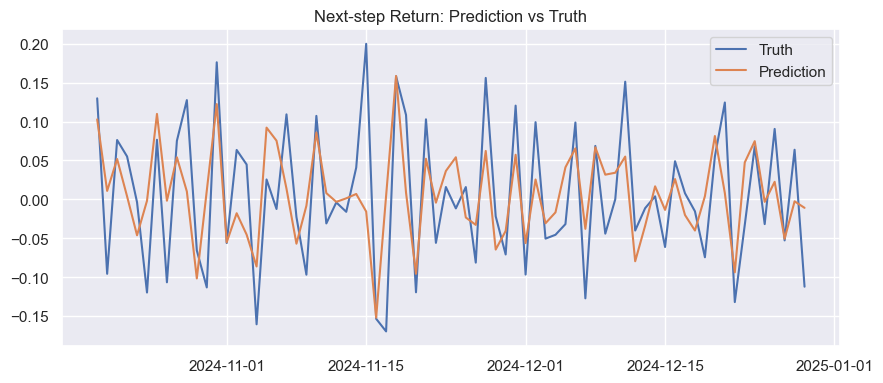

In [ ]:
# Track 1: Forecasting next-step return
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

reg = Pipeline([
    ('scaler', StandardScaler()),
    ('linreg', LinearRegression())
])
reg.fit(X_tr, y_tr_reg)

pred_reg = reg.predict(X_te)

mse  = mean_squared_error(y_te_reg, pred_reg)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_te_reg, pred_reg)
print(f"RMSE = {rmse:.6f} | MAE = {mae:.6f}")

plt.figure()
plt.plot(y_te_reg.index, y_te_reg.values, label='Truth')
plt.plot(y_te_reg.index, pred_reg,        label='Prediction')
plt.title('Next-step Return: Prediction vs Truth')
plt.legend()
plt.tight_layout()
plt.show()


ACC=0.764  P=0.722  R=0.788  F1=0.754

              precision    recall  f1-score   support

           0      0.806     0.744     0.773        39
           1      0.722     0.788     0.754        33

    accuracy                          0.764        72
   macro avg      0.764     0.766     0.763        72
weighted avg      0.767     0.764     0.764        72



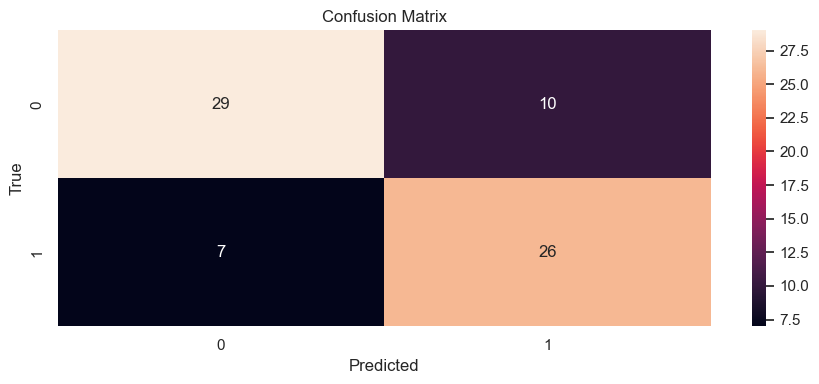

In [ ]:
# Track 2: Classification (up/down)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support

clf = Pipeline([
    ('scaler', StandardScaler()),
    ('logit', LogisticRegression(max_iter=1000))
])
clf.fit(X_tr, y_tr_clf)

pred_cls = clf.predict(X_te)

acc = accuracy_score(y_te_clf, pred_cls)
pr, rc, f1, _ = precision_recall_fscore_support(y_te_clf, pred_cls, average='binary')
print(f"ACC={acc:.3f}  P={pr:.3f}  R={rc:.3f}  F1={f1:.3f}\n")
print(classification_report(y_te_clf, pred_cls, digits=3))

cm = confusion_matrix(y_te_clf, pred_cls)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.tight_layout()
plt.show()


## Interpretation

- **What worked?**  
  Lag and rolling features captured short-term trends, giving reasonable accuracy in both regression (RMSE/MAE) and classification (precision/recall).

- **Where might assumptions fail?**  
  The model assumes past patterns repeat. Shocks such as holidays, promotions, or external events could break these patterns and reduce accuracy.

- **How would you extend features or model?**  
  Add calendar features (day-of-week, holidays), try tree-based models (Random Forest, XGBoost) for nonlinear effects, and validate with TimeSeriesSplit to better assess performance.


### Save Notebook
Remember to save as `notebooks/modeling_<team>.ipynb`.